C:\Users\admin\AppData\Local\Temp\ipykernel_11808\1734209592.py:59: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:278.)
  input_batch = torch.Tensor(input_batch)


Epoch 1000, cost = 1.988569
Epoch 2000, cost = 2.133668
Epoch 3000, cost = 1.563820
Epoch 4000, cost = 1.490436
Epoch 5000, cost = 1.341902
Epoch 6000, cost = 1.179125
Epoch 7000, cost = 1.209313
Epoch 8000, cost = 1.497668
Epoch 9000, cost = 1.039841
Epoch 10000, cost = 1.463239
Epoch 11000, cost = 2.106416
Epoch 12000, cost = 1.511435
Epoch 13000, cost = 1.407205
Epoch 14000, cost = 1.431393
Epoch 15000, cost = 0.595522


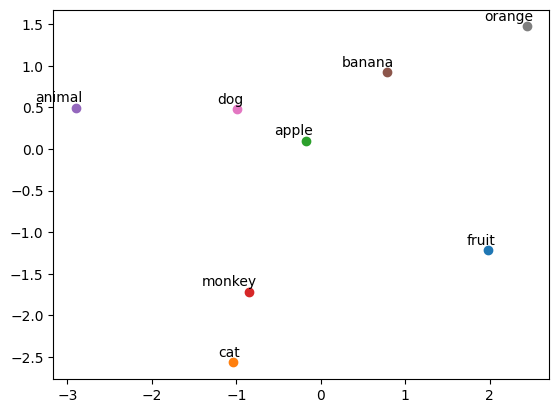

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

def random_batch():
    random_inputs = []
    random_labels = []
    random_index = np.random.choice(range(len(skip_grams)), batch_size, replace=False)

    for i in random_index:
        random_inputs.append(np.eye(voc_size)[skip_grams[i][0]])  # target
        random_labels.append(skip_grams[i][1])  # context word

    return random_inputs, random_labels

# Model
class Word2Vec(nn.Module):
    def __init__(self):
        super(Word2Vec, self).__init__()
        # W and WY is not Transpose Relationship
        self.W = nn.Linear(voc_size, embedding_size, bias=False)  # voc_size > embedding_size Weight
        self.WT = nn.Linear(embedding_size, voc_size, bias=False)  # embedding_size > voc_size Weight

    def forward(self, X):
        # X : [batch_size, voc_size]
        hidden_layer = self.W(X)  # hidden_layer : [batch_size, embedding_size]
        output_layer = self.WT(hidden_layer)
        return output_layer

if __name__=="__main__":
    batch_size = 2
    embedding_size = 2

    sentences = ["apple banana fruit", "banana orange fruit", 'orange banana fruit', 'dog cat animal', 'cat monkey animal', 'monkey dog animal']

    word_sequence = " ".join(sentences).split()
    word_list = " ".join(sentences).split()
    word_list = list(set(word_list))
    word_dict = {w : i for i, w in enumerate(word_list)}
    voc_size = len(word_list)

    # Make skip gram of one size window
    skip_grams = []
    for i in range(1, len(word_sequence) - 1):
        target = word_dict[word_sequence[i]]
        context = [word_dict[word_sequence[i - 1]], word_dict[word_sequence[i + 1]]]
        for w in context:
            skip_grams.append([target, w])
    
    model = Word2Vec()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(15000):
        input_batch, target_batch = random_batch()
        input_batch = torch.Tensor(input_batch)
        target_batch = torch.LongTensor(target_batch)

        optimizer.zero_grad()
        output = model(input_batch)

        # output : [batch size, voc size], target_batch : [batch_size] (LongTensor, not one-hot)
        loss = criterion(output, target_batch)
        if (epoch+1)%1000 == 0:
            print('Epoch {}, cost = {:.6f}'.format(epoch+1, loss))

        loss.backward()
        optimizer.step()

    for i, label in enumerate(word_list):
        W, WT = model.parameters()
        x, y = W[0][i].item(), W[1][i].item()

        plt.scatter(x, y)
        plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords="offset points", ha="right", va="bottom")
    plt.show()

## 네거티브 샘플링
Word2Vec의 출력층에는 소프트맥스 함수를 지난 단어 집합의 크기의 벡터와 실제값인 원핫 벡터와의 오차를 구하고 이로부터 임베딩 벡터 값을 업데이트합니다. 만약 단어 집합의 크기가 수만 이상에 달한다면 이 작업은 굉장히 무거운 작업이므로, Word2Vec은 꽤나 학습하기에 무거운 모델이 됩니다.

Word2Vec은 역전파 과정에서 모든 단어의 임베딩 벡터값의 업데이트를 수행하지만, 만약 현재 집중하고 있는 중심 단어와 주변 단어가 '강아지'와 '고양이', '귀여운'과 같은 단어라면, 사실 이 단어들과 별 연관 관계가 없는 '돈가스'나 '컴퓨터'와 같은 수많은 단어의 임베딩 벡터값까지 업데이트하는 것은 비효율적입니다.

네거티브 샘플링은 **Word2Vec이 학습 과정에서 전체 단어 집합이 아니라 일부 단어 집합에만 집중할 수 있도록 하는 방법**입니다. 가령 현재 집중하고 있는 주변 단어가 '고양이', '귀여운'이라고 해봅시다. 여기에 '돈가스', '컴퓨터', '회의실'과 같은 단어 집합에서 무작위로 선택된 주변 단어가 아닌 단어들을 일부 가져옵니다. 이렇게 하나의 중심 단어에 대해서 전체 단어 집합보다 훨씬 작은 단어 집합을 만들어 놓고 마지막 단계를 이진 분류 문제로 변환합니다. 주변 단어들을 긍정(positive), 랜덤으로 샘플링 된 단어들을 부정(negative)으로 레이블링한다면 이진 분류 문제를 위한 데이터셋이 됩니다. 이는 기존의 단어 집합의 크기만큼의 선택지를 두고 다중 클래스 분류 문제를 풀던 Word2Vec보다 훨씬 연산량에서 효율적입니다.

## 네거티브 샘플링 Skip-gram

> The fat cat sat on the mat

skip-gram은 중심 단어로부터 주변 단어를 예측하는 모델이다. 위와 같은 문장이 있다고 한다면, Skip-Gram은 중심 단어인 cat으로 부터 주변 단어인 The, sat, on을 예측한다. 기존의 Skip-gram은 입력으로 cat이 주어지고, 예측으로 주변 단어가 output으로 나오는 구조이다.

하지만 네거티브 샘플링을 사용하는 Skip-Gram(SGNS)는 이와는 다른 접근 방식을 취합니다. 주변단어와 중심단어가 모두 input으로 입력되고, 이 두 단어가 실제로 window size 내에 존재하는 이웃 관계인지 그 확률을 예측한다.

기존의 Skip-gram 데이터셋을 SGNS의 데이터셋으로 바꾸는 과정은 아래와 같다.

<img src="./images_for_markdown/SGtoSGNS.png">

위의 그림에서 좌측의 테이블은 기존의 skip-gram을 학습하기 위한 데이터셋입니다. Skip-gram은 기본적으로 중심 단어를 입력, 주변 단어를 레이블로 합니다. 하지만 SGNS를 학습하고 싶다면, 이 데이터셋을 우측의 테이블과 같이 수정할 필요가 있습니다. 우선, **기존의 Skip-gram 데이터셋에서 중심 단어와 주변 단어를 각각 입력1, 입력2**로 둡니다. 이 둘은 실제로 윈도우 크기 내에서 이웃 관계였으므로, **레이블은 1**로 합니다. 이제 레이블이 0인 샘플들을 준비할 차례입니다.

<img src="./images_for_markdown/SGNS-data.png">

실제로는 입력1(중심 단어)와 주변 단어 관계가 아닌 단어들을 입력2로 삼기 위해서 **단어 집합에서 랜덤으로 선택한 단어들을 입력2**로 하고, **레이블을 0**으로 합니다. 이제 이 데이터셋은 입력1과 입력2가 실제로 윈도우 크기 내에서 이웃 관계인 경우에는 레이블이 1, 아닌 경우에는 레이블이 0이 됩니다. 그리고 이제 두 개의 임베딩 테이블을 준비합니다. 두 임베딩 테이블은 훈련 데이터의 단어 집합의 크기를 가지므로 크기가 같습니다.

<img src="./images_for_markdown/embedding_table.png">

두 테이블 중 하나는 입력1인 중심 단어의 룩업 테이블을 위한 임베딩 테이블이고, 하나는 입력2인 주변 단어의 룩업테이블을 위한 임베딩 테이블입니다. 각 단어는 각 임베딩 테이블을 룩업 테이블하여 임베딩 벡터로 변환됩니다.

<img src="./images_for_markdown/embedding.png">

각 임베딩 테이블을 통해 룩업 테이블 하며 임베딩 벡터로 변환되었다면 그 후의 연산은 매우 간단합니다.

<img src="./images_for_markdown/embedding_vec_update.png">

중심 단어와 주변 단어의 내적값을 이 모델의 예측값으로 하고, 레이블과의 오차로부터 역전파 하며 중심 단어와 주변 단어의 임베딩 벡터값을 업데이트합니다. 학습 후에는 좌측의 임베딩 행렬을 임베딩 벡터로 사용할 수도 있고, 두 행렬을 더한 후 사용하거나 두 행렬을 연결(concatenate)해서 사용할 수도 있습니다. 아래의 실습에서는 좌측의 행렬을 사용하는 방식을 택했습니다.

In [1]:
import pandas as pd
import numpy as np
import nltk

from nltk.corpus import stopwords
from sklearn.datasets import fetch_20newsgroups
from keras.preprocessing.text import Tokenizer

20뉴스 그룹 데이터셋으로 실습을 진행합니다. 

해당 실습에서는 하나의 샘플에 최소 2개의 단어가 있어야합니다. 그래야만 중심 단어, 주변 단어의 관계가 성립하며 그렇지 않으면 샘플을 구성할 수 없어 오류가 발생합니다. 전처리 과정에서 지속적으로 이를 만족하지 않는 샘플들을 제거합니다.

In [2]:
dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=("headers", "footers", "quotes"))
documents = dataset.data
print("총 샘플 수 : ", len(documents))

총 샘플 수 :  11314


총 샘플 수는 11,314개 입니다. 전처리를 진행하며 불필요한 토큰을 제거하고, 소문자화를 통해 정규화를 진행합니다.

In [3]:
news_df = pd.DataFrame({"document":documents})
news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z]", " ")  # 특수문자 제거
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 3]))  # 길이가 3 이하인 문자들 제거
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: x.lower())


In [4]:
news_df.isnull().values.any()  # 결측치 확인

False

In [5]:
news_df.replace("", float("NaN"), inplace=True)  # 빈 값을 결측치로 치환해서 다시 확인
news_df.isnull().values.any()

True

In [6]:
news_df.dropna(inplace=True)  # 결측치 제거
print('총 샘플 수 : ', len(news_df))

총 샘플 수 :  11004


In [7]:
# 불용어 제거
stop_words = stopwords.words("english")
tokenized_doc = news_df['clean_doc'].apply(lambda x: x.split())
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])
tokenized_doc = tokenized_doc.to_list()

In [8]:
drop_train = [index for index, sentence in enumerate(tokenized_doc) if len(sentence) <= 1]
tokenized_doc = np.delete(tokenized_doc, drop_train, axis=0)
print("총 샘플 수 : ", len(tokenized_doc))

총 샘플 수 :  10961


c:\Users\admin\miniconda3\envs\mynlp\lib\site-packages\numpy\lib\function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


In [9]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tokenized_doc)

word2idx = tokenizer.word_index
idx2word = {val : key for key, val in word2idx.items()}
encoded = tokenizer.texts_to_sequences(tokenized_doc)


In [10]:
encoded[:2]

[[40,
  53,
  927,
  143,
  15889,
  1684,
  546,
  279,
  871,
  12028,
  17773,
  24007,
  29726,
  279,
  871,
  63435,
  871,
  1128,
  1103,
  1998,
  851,
  29727,
  913,
  731,
  20477,
  279,
  871,
  170,
  143,
  1811,
  149,
  279,
  20478,
  17773,
  6645,
  5710,
  76,
  63436,
  7,
  36,
  165,
  614,
  653,
  29728,
  6911,
  24008,
  2082,
  829,
  17774,
  1119,
  8790,
  355,
  1072,
  15890,
  671,
  57,
  163,
  4231,
  7206,
  1933,
  440,
  56,
  282,
  4730,
  9275,
  2690,
  39306],
 [1283,
  429,
  3,
  52,
  6164,
  159,
  112,
  474,
  89,
  17775,
  18,
  63,
  4731,
  2865,
  63437,
  1042,
  402,
  39307,
  8791,
  902,
  44,
  8328,
  316,
  13041,
  902,
  3452,
  5923,
  533,
  18,
  87,
  4732,
  9872,
  160,
  1403,
  120,
  151,
  5194,
  63438,
  63439,
  17776,
  63440,
  13041,
  903,
  63441,
  63442,
  11172,
  17777]]

In [12]:
vocab_size = len(word2idx) + 1

print("단어 집합의 크기 : ", vocab_size)

단어 집합의 크기 :  181839


## 네거티브 샘플링을 통한 데이터셋 구성하기

토큰화, 정제, 정규화, 불용어 제거, 정수 인코딩까지 일반적인 전처리 과정을 거쳤습니다. 네거티브 샘플링을 통한 데이터셋을 구성할 차례입니다.

이를 위해서는 네커티브 샘플링을 위해서 케라스에서 제공하는 전처리 도구인 skipgrams를 사용합니다. 어떤 전처리가 수행되는지 그 결과를 확인하기 위해서 상위 10개의 뉴스 그룹 샘플에 대해서만 수행해 봅니다.

In [13]:
from tensorflow.keras.preprocessing.sequence import skipgrams

skip_grams = [skipgrams(sample, vocabulary_size=vocab_size, window_size=10) for sample in encoded[:10]]

In [14]:
# 첫 번째 샘플인 skip_grams[0] 내 skipgrams로 형성된 데이터셋 확인
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(5):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
        idx2word[pairs[i][0]], pairs[i][0],
        idx2word[pairs[i][1]], pairs[i][1],
        labels[i]
        ))

(shame (6911), soldiers (1072)) -> 1
(soldiers (1072), 20's (22525)) -> 0
(biased. (15889), media (871)) -> 1
(commited (8790), dickering (97764)) -> 0
(media (871), world. (1128)) -> 1


윈도우 크기 내에서 중심 단어, 주변 단어의 관계를 가지는 경우에는 1의 레이블을 갖도록 하고, 그렇지 않은 경우는 0의 레이블을 가지도록 하여 데이터셋을 구성합니다.

이 과정은 각각의 뉴스그룹 샘플에 대해서 동일한 프로세스로 수행됩니다.

In [15]:
print('전체 샘플 수 : ', len(skip_grams))

전체 샘플 수 :  10


encoded 중 상위 10개의 뉴스그룹 샘플에 대해서만 수행하였으므로 10이 출력됩니다. 그리고 10개의 뉴스그룹 샘플 각각은 수많은 중심 단어, 주변 단어의 쌍으로 된 샘플들을 갖고 있습니다. 첫 번째 뉴스그룹 샘플이 가지고 있는 pairs와 labels의 개수를 출력해봅니다.

In [16]:
print(len(pairs))
print(len(labels))

2460
2460


In [17]:
# 모든 뉴스그룹 샘플에 대해 수행
skip_grams = [skipgrams(sample, vocabulary_size=vocab_size, window_size=10) for sample in encoded]

### Skip-Gram with Negative Sampling(SGNS) 구현하기


In [18]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Reshape, Activation, Input, Dot
from tensorflow.keras.utils import plot_model
from IPython.display import SVG

하이퍼 파라미터인 임베딩 벡터의 차원은 100으로 정하고, 두 개의 임베딩 층을 추가합니다.

In [19]:
embedding_dim = 100

# 중심 단어를 위한 임베딩 테이블
w_inputs = Input(shape=(1, ), dtype="int32")
word_embedding = Embedding(vocab_size, embedding_dim)(w_inputs)

# 주변 단어를 위한 임베딩 테이블
c_inputs = Input(shape=(1, ), dtype="int32")
context_embedding = Embedding(vocab_size, embedding_dim)(c_inputs)

각 임베딩 테이블은 중심 단어와 주변 단어 각각을 위한 임베딩 테이블이며 각 단어는 임베딩 테이블을 거쳐서 내적을 수행하고, 내적의 결과는 1 또는 0을 예측하기 위해서 시그모이드 함수를 활성화 함수로 거쳐 최종 예측값을 얻습니다.

In [21]:
dot_product = Dot(axes=2)([word_embedding, context_embedding])
dot_product = Reshape((1, ), input_shape=(1, 1))(dot_product)
output = Activation("sigmoid")(dot_product)

model = Model(inputs=[w_inputs, c_inputs], outputs=output)
model.summary()
model.compile(loss="binary_crossentropy", optimizer="adam")
plot_model(model, to_file="model3.png", show_shapes=True, show_layer_names=True, rankdir="TB")

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 100)       18183900    ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 100)       18183900    ['input_2[0][0]']                
                                                                                            

In [24]:
for epoch in range(1, 6):
    loss = 0
    for _, elem in enumerate(skip_grams):
        first_elem = np.array(list(zip(*elem[0]))[0], dtype="int32")
        second_elem = np.array(list(zip(*elem[0]))[1], dtype="int32")
        labels = np.array(elem[1], dtype="int32")
        X = [first_elem, second_elem]
        Y = labels

        loss += model.train_on_batch(X, Y)
    print("Epoch : {} Loss : {}".format(epoch, loss))

In [ ]:
import gensim

with open('vectors.txt', 'w') as f:
    f.write("{} {}\n".format(vocab_size-1, embedding_dim))

    vectors = model.get_weights()[0]
    for word, i in tokenizer.word_index.items():
        f.write('{} {}\n'.format(word, " ".join(map(str, list(vectors[i, :])))))
    
    f.close()

w2v = gensim.models.KeyedVectors.load_word2vec_format("./vectors.txt", binary=False)

In [ ]:
w2v.most_similar(positive=['soldiers'])